# Factory Polar Code

## Initialization

In [5]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.qasm2 import dumps

import mysql.connector
import networkx as nx
import os
import sys

from qEmQUIP import QEM, conf
import mysql.connector

module_path = os.path.abspath(os.path.join('.', 'wrappers'))
if module_path not in sys.path:
    sys.path.append(module_path)

from commons import (
    used_qubits, sum_middle_digits_dict
)

from wrappers.multiprogramming_wrapper import (
    avoid_simultaneous_cnot, add_zz_on_simultaneous_cnot, 
    build_idle_coupling_map, multiprogram_compilation_qiskit, merge_circuits,
    get_LF_presets_cm
)
from wrappers.polar_wrapper import (
        polar_code_p2, get_logical_error_on_accepted_states
)

from wrappers.prune_wrapper import (
    create_full_graph, generate_figures, generate_node_errors, generate_edge_errors,
    get_latest_calibration_id, get_edges_threshold, get_readout_threshold, get_LF_qubits
)


# MySQL connection parameters
mysql_config = {
    'user': 'handy',
    'password': 'handy',
    'host': 'ec2-16-171-135-24.eu-north-1.compute.amazonaws.com',
    'database': 'calibration_data'
}

# Connect to the MySQL database
conn = mysql.connector.connect(**mysql_config)

shots = 10000

In [2]:
# # handykur@ucm.es
# token = "476ea8c61cc54f36e4a21d70a8442f94203c9d87096eaad0886a3e8154d8c2e79bcad6f927c6050a76335dd68d783f478c1b828504748a4377b441c335c831aa"

# # pepedelft1@gmail.com
# token = "fdefbc37eda82465c039f2936eb9a6cafc1b4e83ebd0dadba02134ca359d319b7941e4b52329ca8e3d3124fcbdc93eedb237c50ec7d830ac2dce36c032776d7b"

# # pepedelft2@gmail.com
# token = "30366d1081faaba964ab5517685984096bca752b7f7bab6f4de8d2484d2190902c448ed97fb2f52c6ca0ab6751ee45019dc92b5f79a2fdba1d183d16227f1467"

# # # pepedelft4@gmail.com
# token = "1588e1002177933e6a824a5501e7f0a93dc1086281aae7c9194959af683e42346e5892b6aec8cd1b096720508942a4b4bfdfac0118e7914c670c244ada1bd38c"

# # pepeucm1@gmail.com
token = "9e068d694502429634a4706a9f08781beac043c44af9642dfe89757093b049ba266b0ce9f488d4220d386114b5f785a518827881e0645b530203026ad7ab9d7e"

hw_name = "ibm_sherbrooke"
QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)
service = QiskitRuntimeService(channel="ibm_quantum", token=token)
# backend = service.backend("ibm_kyiv")
backend = service.backend(hw_name)

In [3]:
# hw_name = "ibm_fez"
hw_name = "ibm_marrakesh"
# hw_name = "ibm_kyiv"
service = QiskitRuntimeService(channel="ibm_cloud", token="tyF4ya7NOGlq9Ls_JM5JJ0vG0IJmdu_Ea2rc-xTauvJ_", instance="ibm_credit")
backend = service.backend(hw_name)
backend.name

'ibm_marrakesh'

In [3]:
list_circuit_name = []
list_n = []
list_logical = []
polar_circuits = {}
polar_circuits_meas_data = {}
polar_circuits_x = {}
polar_circuits_x_meas_data = {}

print("-------- z -----------")
for i in range(2,7):
    list_circuit_name.append("polar_z_n{}".format(i))
    list_n.append(i)
    list_logical.append("0")
    polar_circuits[i] = (polar_code_p2(i, base="z"))
    polar_circuits_meas_data[i] = (polar_code_p2(i, meas_data=True, base="z"))
    #polar_circuits_x[i] = (polar_code_p2(i, base="x"))
    #polar_circuits_x_meas_data[i] = (polar_code_p2(i, meas_data=True, base="x"))

print("-------- x -----------")
for i in range(2,7):
    list_circuit_name.append("polar_x_n{}".format(i))
    list_n.append(i)
    list_logical.append("+")
    #polar_circuits[i] = (polar_code_p2(i, base="z"))
    # polar_circuits_meas_data[i] = (polar_code_p2(i, meas_data=True, base="z"))
    polar_circuits_x[i] = (polar_code_p2(i, base="x"))
    polar_circuits_x_meas_data[i] = (polar_code_p2(i, meas_data=True, base="x"))

-------- z -----------
n = 2 , b = 10 (1) , i = 2
n = 2 , b = 10 (1) , i = 2
n = 3 , b = 110 (3) , i = 4
n = 3 , b = 110 (3) , i = 4
n = 4 , b = 0110 (6) , i = 7
n = 4 , b = 0110 (6) , i = 7
n = 5 , b = 11100 (7) , i = 8
n = 5 , b = 11100 (7) , i = 8
n = 6 , b = 011010 (22) , i = 23
n = 6 , b = 011010 (22) , i = 23
-------- x -----------
n = 2 , b = 00 (0) , i = 1
n = 2 , b = 00 (0) , i = 1
n = 3 , b = 010 (2) , i = 3
n = 3 , b = 010 (2) , i = 3
n = 4 , b = 1010 (5) , i = 6
n = 4 , b = 1010 (5) , i = 6
n = 5 , b = 01100 (6) , i = 7
n = 5 , b = 01100 (6) , i = 7
n = 6 , b = 101010 (21) , i = 22
n = 6 , b = 101010 (21) , i = 22


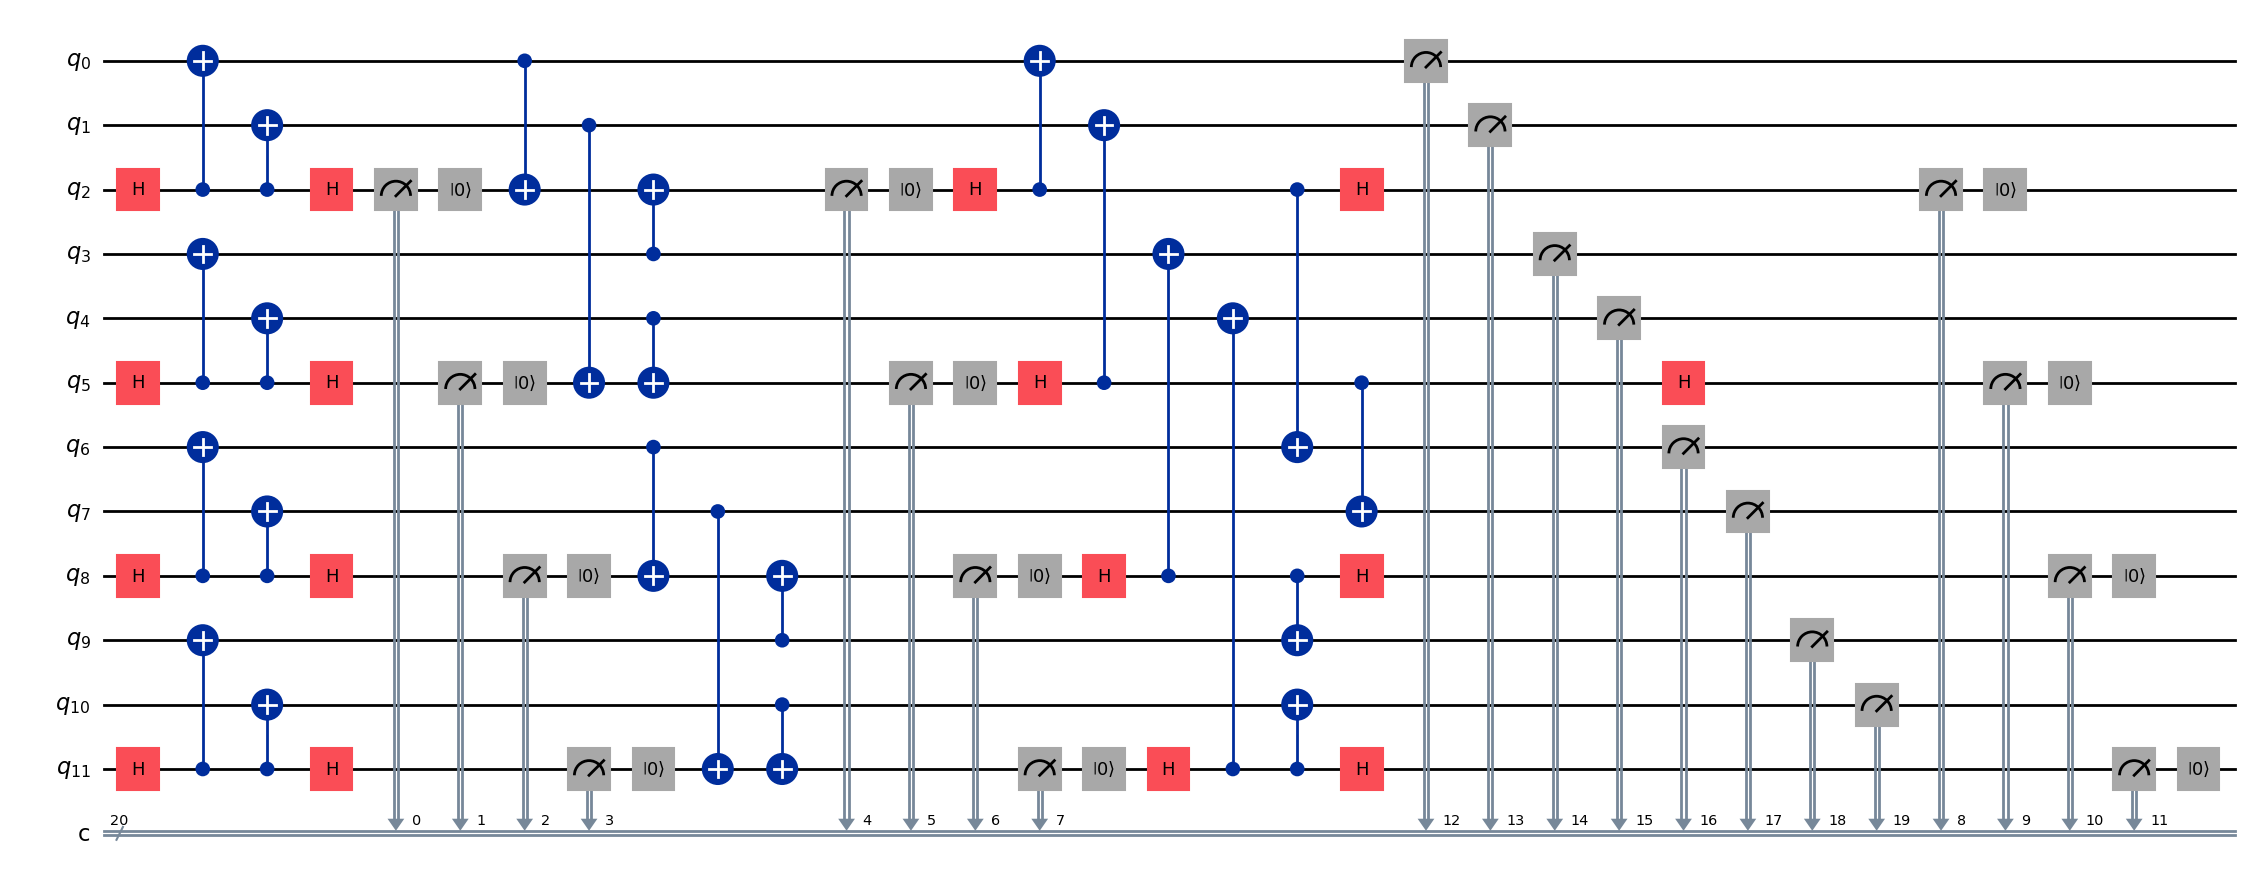

In [4]:
polar_circuits_x_meas_data[3].draw("mpl", idle_wires=False, fold=-1)

In [5]:
# compiled_circuits = multiprogram_compilation_qiskit([polar_circuits_x[3]]*7,backend)
# circ = polar_circuits_x_meas_data[3]
circ = polar_circuits_x_meas_data[3]
circ_name = "n3_x"
reps = 6
compiled_circuits = multiprogram_compilation_qiskit([circ]*reps,backend)

In [6]:
num_qubits = circ.num_qubits
num_clbits = circ.num_clbits
total_num_clbits = circ.num_clbits * reps
print(num_qubits, num_clbits, total_num_clbits)

12 20 120


In [7]:
final_circuit = merge_circuits(compiled_circuits, backend, num_cbits=total_num_clbits)
final_circuit_q3_normal = final_circuit

In [8]:
print(used_qubits(final_circuit_q3_normal))

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 17, 20, 21, 22, 29, 30, 31, 32, 33, 36, 37, 38, 39, 41, 42, 43, 44, 45, 53, 54, 60, 61, 62, 63, 64, 68, 69, 70, 73, 74, 75, 76, 77, 78, 79, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104, 105, 106, 110, 111, 118]


In [9]:
# final_circuit.draw("mpl", idle_wires=False, fold=30, plot_barriers=True)

In [10]:
pubs = []
for i in compiled_circuits:
    pubs.append(i["circuit"])

pubs.append(final_circuit)

In [11]:
# pubs_zz = []
# pubs_clean = []
# pubs_clean_zz = []

# for qc in pubs:
#     pubs_zz.append(add_zz_on_simultaneous_cnot(qc, backend))

#     tmp = avoid_simultaneous_cnot(qc, backend)
#     tmp = avoid_simultaneous_cnot(tmp, backend)
#     tmp = avoid_simultaneous_cnot(tmp, backend)
#     pubs_clean.append(tmp)
#     pubs_clean_zz.append(add_zz_on_simultaneous_cnot(tmp, backend))

In [12]:
# pubs_zz_ops = []
# pubs_clean_zz_ops = []

# for idx, i in enumerate(pubs):
#     pubs_zz_ops.append(pubs_zz[idx].count_ops())
#     pubs_clean_zz_ops.append(pubs_clean_zz[idx].count_ops())

In [13]:
# pubs_zz_ops[-1]

In [14]:
# pubs_clean_zz_ops[-1]

## Submit to Backend

In [15]:
# from qiskit_ibm_runtime import SamplerV2 as Sampler
# from qiskit_ibm_runtime.options import SamplerOptions

# options = SamplerOptions(
#                 default_shots=10000,
#                 # dynamical_decoupling=dd_options,
#                 # twirling= twirling_options
#             )
# sampler = Sampler(mode=backend, options=options) 

In [16]:
# job = sampler.run(pubs)
# print(job.job_id())

In [17]:
# job = sampler.run(pubs_clean)
# print(job.job_id())

## Get Result

In [30]:
# # # handykur@ucm.es
# # token = "476ea8c61cc54f36e4a21d70a8442f94203c9d87096eaad0886a3e8154d8c2e79bcad6f927c6050a76335dd68d783f478c1b828504748a4377b441c335c831aa"

# # polar n3 x, 2 circuits, kyiv, qiskit-3
# # job  = service.job("cza4691hfwp00087xd2g") # simultaneous cx
# job  = service.job("cza46bsb7tt0008g4nn0") # clean simultaneous cx

# # polar n3 x, 7 circuits, kyiv, qiskit-3
# # job  = service.job("cza5ajaqadq0008c7spg") # simultaneous cx
# # job  = service.job("cza5ak2r3jrg008nww70") # clean simultaneous cx


In [31]:
# from qiskit.providers.jobstatus import JobStatus
# fidelities = []

# if job.status() == JobStatus.ERROR:
#     logger.error("job error")
#     exit(1)

# inputs_pubs = job.inputs["pubs"]

# job_pubs = []
# for c in inputs_pubs:
#     job_pubs.append(c[0])
#     print(used_qubits(c[0]), len(used_qubits(c[0])))

# qc = job_pubs[-1]
# used_qbs = used_qubits(qc)
# print(used_qubits(qc), len(used_qubits(qc)))

# result = job.result()  

# # sim_noiseless = AerSimulator()
# # ideal_jobs = sim_noiseless.run(job_pubs[0], shots=10000)
# # ideal_results = ideal_jobs.result()
# # ideal_counts = ideal_results.get_counts()

# hardware_counts = []

# for h in result:
#     hardware_counts.append(h.data.c.get_counts())

# len(hardware_counts)

# get the individual result - state preparation
# n = 3
# lstate = "X"
# for i in range(7):
#     print(f"Reps-{i}")
#     tmp = sum_middle_digits_dict(hardware_counts[i], -12, None)
#     print(get_q1prep_sr(n, lstate, tmp))

# get the individual result - logical error rate
# n = 3
# lstate = "X"
# for i in range(7):
#     print(f"Reps-{i}")
#     tmp = hardware_counts[i]
#     get_logical_error_on_accepted_states(n, lstate, tmp)

[23, 24, 25, 34, 40, 41, 42, 43, 53, 59, 60, 61] 12
[73, 82, 83, 84, 85, 86, 92, 102, 103, 104, 105, 111] 12
[23, 24, 25, 34, 40, 41, 42, 43, 53, 59, 60, 61, 73, 82, 83, 84, 85, 86, 92, 102, 103, 104, 105, 111] 24


In [ ]:
# # get result multiprog on individual algorithm for polar code

# end_index = 0
# start_index = None

# for i in range(reps):
#     end_index = end_index - num_clbits

#     res = sum_middle_digits_dict(hardware_counts[-1], end_index, start_index)
#     print(f"Reps-{i}")
#     print(get_logical_error_on_accepted_states(n, lstate, res))

#     start_index = end_index
    


In [29]:
# # get result multiprog in total state preparation

# total_accepted = 0

# for key, value in hardware_counts[-1].items():
#     end_index = 0
#     start_index = None
    
#     # print(key, value)
    

#     total_count_accept = 0
#     for i in range(reps):
#         end_index = end_index - num_clbits

#         tmp_dict = {key[end_index : start_index]:1}
        
#         # res = sum_middle_digits_dict(hardware_counts[-1], end_index, start_index)
#         # print(f"Reps-{i}")
#         count_accept, _, _, _, _, _ =   get_logical_error_on_accepted_states(n, lstate, tmp_dict)
#         total_count_accept = total_count_accept + count_accept
        
#         start_index = end_index

#     if total_count_accept > 0:
#         total_accepted = total_accepted + 1
    
#     # break

# total_accepted

## Plot used qubits

In [17]:
conf = backend.configuration()
prop = backend.properties()

conf_dict = conf.to_dict()
prop_dict = prop.to_dict()

qubits_no = backend.num_qubits

cm = backend.coupling_map
cm_sorted = [sorted(pair) for pair in cm]
cm_sorted = sorted(cm_sorted)

coords = conf_dict["coords"]

In [18]:
# used_qbs = [0, 14, 18, 40, 41, 42, 53, 81, 82, 83, 84, 91, 92, 96, 97, 98, 99, 110, 117, 118, 119, 120]
used_qbs = used_qubits(final_circuit_q3_normal)

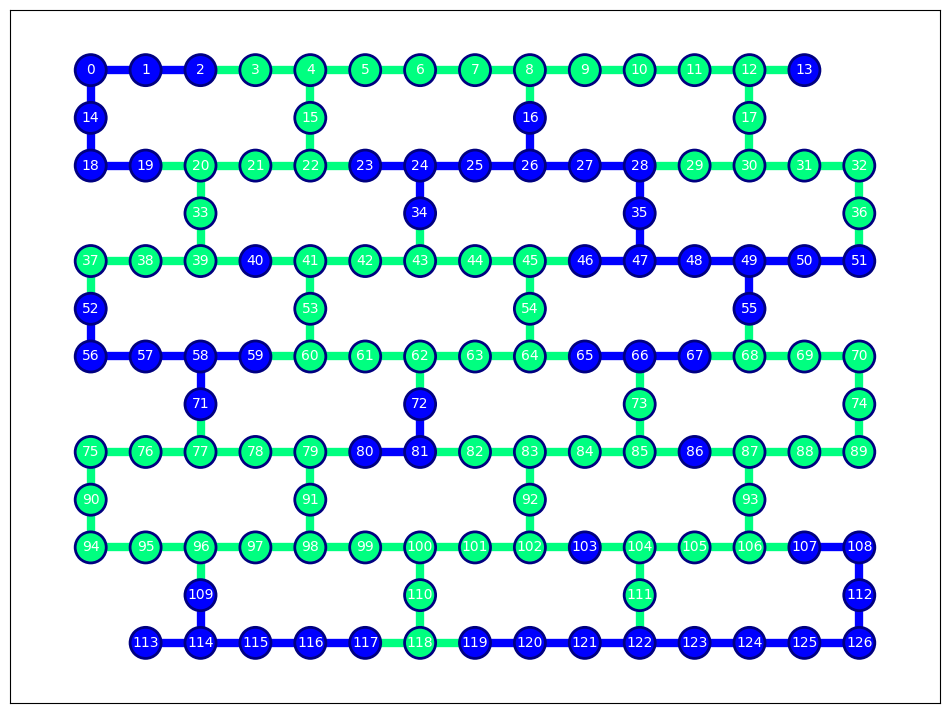

In [19]:
edge_weights = {}

for control, target in cm:
    if control in used_qbs or target in used_qbs:
        edge_weights[(control, target)] = 1
        edge_weights[(target, control)] = 1
    else:
        edge_weights[(control, target)] = 0
        edge_weights[(target, control)] = 0
        
G, pos = create_full_graph(cm_sorted, coords, edge_weights)

edge_colors = ["navy"]*qubits_no

node_errors = []

edge_errors = []

for idx, j in enumerate(G.nodes()):
    if j in used_qbs :
        node_errors.append(1)
    else:
        node_errors.append(0)

for i in G.edges():
    edge_errors.append(G.get_edge_data(i[0],i[1])["weight"])
    #print(G.get_edge_data(i[0],i[1])["weight"])

plt = generate_figures(G,pos, node_errors, edge_errors, title="", edge_colors=edge_colors)
# plt.show()
# plt.tight_layout()
plt.savefig(f"mp_{hw_name}_q-3_polar_{circ_name}_{reps}.png", dpi=500)
# plt.savefig("kyiv_+_11_70k_hotmap.png", dpi=500)

# Prune 

## Normal

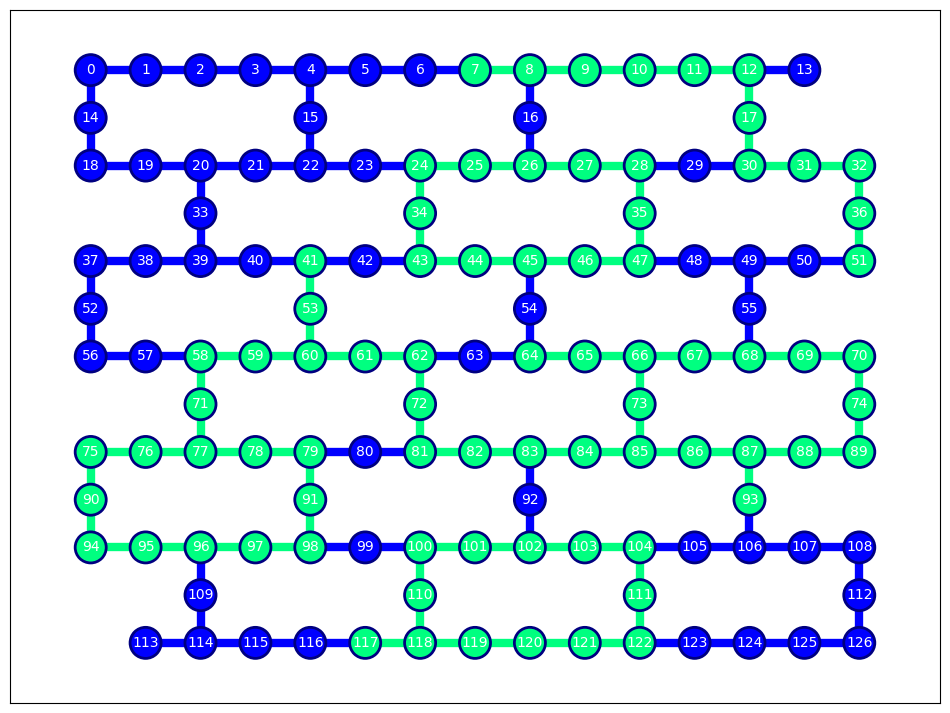

In [20]:
# hw_name = "ibm_sherbrooke"

# compiled_circuits = multiprogram_compilation_qiskit([polar_circuits_x[3]]*7,backend)
# circ = polar_circuits_meas_data[4]
# circ_name = "n4_z"
# reps = 1

circ = polar_circuits_x_meas_data[3]
circ_name = "n3_x"
reps = 6

# circ = polar_circuits_x_meas_data[4]
# reps = 1
# circ_name = "n4_x"
compiled_circuits = multiprogram_compilation_qiskit([circ]*reps,backend)

num_clbits = circ.num_clbits
total_num_clbits = circ.num_clbits * reps

final_circuit = merge_circuits(compiled_circuits, backend, num_cbits=total_num_clbits)
final_circuit_q3_normal = final_circuit

used_qbs = used_qubits(final_circuit_q3_normal)

edge_weights = {}

for control, target in cm:
    if control in used_qbs or target in used_qbs:
        edge_weights[(control, target)] = 1
        edge_weights[(target, control)] = 1
    else:
        edge_weights[(control, target)] = 0
        edge_weights[(target, control)] = 0
        
G, pos = create_full_graph(cm_sorted, coords, edge_weights)

edge_colors = ["navy"]*qubits_no

node_errors = []

edge_errors = []

for idx, j in enumerate(G.nodes()):
    if j in used_qbs :
        node_errors.append(1)
    else:
        node_errors.append(0)

for i in G.edges():
    # edge_errors.append(G.get_edge_data(i[0],i[1])["weight"])

    if i[0] in used_qbs and i[1] in used_qbs:
        edge_errors.append(1)
    else:
        edge_errors.append(0)

plt = generate_figures(G,pos, node_errors, edge_errors, title="", edge_colors=edge_colors)
# plt.show()
# plt.tight_layout()
plt.savefig(f"mp_{hw_name}_q-3_polar_{circ_name}_{reps}.png", dpi=500)
# plt.savefig("kyiv_+_11_70k_hotmap.png", dpi=500)

In [21]:
print(num_clbits, len(used_qbs))

20 77


## CX Error

In [22]:
# hw_name = "ibm_kyiv"
# hw_name = "ibm_fez"
# hw_name = "ibm_sherbrooke"
# hw_name = "ibm_brisbane"


threshold_CX = 0.045
threshold_readout = 0.10

# threshold_CX = 0.008
# threshold_readout = 0.015

last_cal_id, cal_datetime = get_latest_calibration_id(hw_name, conn)
print(last_cal_id, cal_datetime)

cal_id = last_cal_id
# edges_list, nodes_list = get_edges_threshold(hw_name, threshold)
nodes_list_CX = get_edges_threshold(hw_name, threshold_CX, conn, cal_id)
nodes_list_readout = get_readout_threshold(hw_name, threshold_readout, conn, cal_id)

nodes_list = list(set(nodes_list_CX).union(nodes_list_readout))
print(len(nodes_list_CX), len(nodes_list_readout), len(nodes_list))

70135 2025-03-20 12:24:18
10 7 15


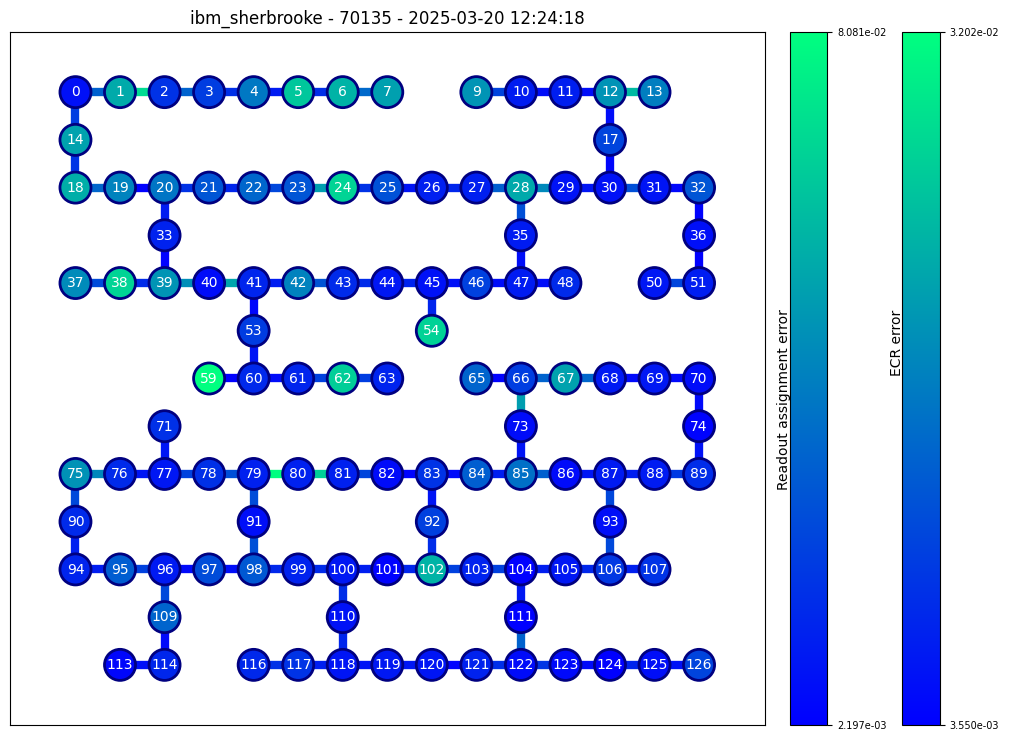

In [23]:
G, pos = create_full_graph(cm_sorted, coords, edge_weights)

# Remove Nodes
for n in nodes_list:
    G.remove_node(n)

cal_id = last_cal_id
node_errors = generate_node_errors(G, conn, cal_id)
edge_errors = generate_edge_errors(G, conn, cal_id)

plt = generate_figures(G, pos, node_errors, edge_errors, show_bar = True, title=f"{hw_name} - {cal_id} - {cal_datetime}")
plt.show()

In [24]:
# Get the connected components as a list of sets of nodes
connected_components = list(nx.connected_components(G))

# Count the number of connected components (trees)
num_trees = len(connected_components)

# Find the size of the largest connected component
max_nodes = max(len(component) for component in connected_components)

print(f"Number of disconnected trees: {num_trees}")
print(f"Maximum number of nodes in a tree: {max_nodes}")

Number of disconnected trees: 2
Maximum number of nodes in a tree: 58


In [25]:
idx = 0
flag_success = False

while not flag_success:

    try:
        # circ = polar_circuits_x_meas_data[3]
        # reps = 8
        compiled_circuits = multiprogram_compilation_qiskit([circ]*reps,backend, exclude_qubits = nodes_list_CX)
        
        num_clbits = circ.num_clbits
        total_num_clbits = circ.num_clbits * reps
        total_num_clbits

        flag_success = True
    
    except:
        idx = idx + 1
        print(f"retry-{idx}")
        if idx > 50:
            flag_success = True

In [26]:
final_circuit_qc_cx = merge_circuits(compiled_circuits, backend, num_cbits=total_num_clbits)

In [27]:
used_qbs = used_qubits(final_circuit_qc_cx)
edge_weights = {}

for control, target in cm:
    if control in used_qbs or target in used_qbs:
        edge_weights[(control, target)] = 1
        edge_weights[(target, control)] = 1
    else:
        edge_weights[(control, target)] = 0
        edge_weights[(target, control)] = 0

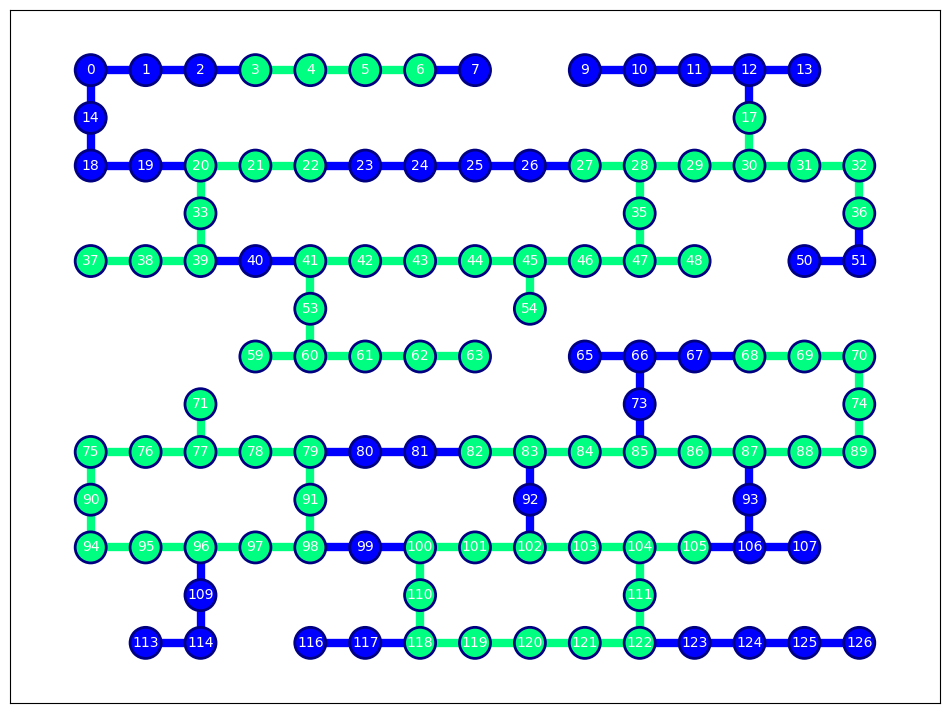

In [28]:
G, pos = create_full_graph(cm_sorted, coords, edge_weights)

edge_colors = ["navy"]*qubits_no

# Remove Nodes
for n in nodes_list:
    G.remove_node(n)

node_errors = []
edge_errors = []

for idx, j in enumerate(G.nodes()):
    if j in used_qbs :
        node_errors.append(1)
    else:
        node_errors.append(0)

for i in G.edges():
    # edge_errors.append(G.get_edge_data(i[0],i[1])["weight"])

    if i[0] in used_qbs and i[1] in used_qbs:
        edge_errors.append(1)
    else:
        edge_errors.append(0)

plt = generate_figures(G,pos, node_errors, edge_errors, title="", edge_colors=edge_colors)
# plt.show()
# plt.tight_layout()
plt.savefig(f"mp_{hw_name}_q-3-cxro_polar_{circ_name}_{reps}.png", dpi=500)
# plt.savefig("kyiv_+_11_70k_hotmap.png", dpi=500)

## Readout

In [29]:
# hw_name = "ibm_kyiv"
# hw_name = "ibm_fez"
# hw_name = "ibm_brisbane"
# threshold_CX = 0.035
# threshold_readout = 0.15

# threshold_CX = 0.035
# threshold_readout = 0.10

cal_id, cal_datetime = get_latest_calibration_id(hw_name, conn)
print(cal_id, cal_datetime)

# edges_list, nodes_list = get_edges_threshold(hw_name, threshold)
nodes_list_CX = get_edges_threshold(hw_name, threshold_CX, conn, cal_id)
nodes_list_readout = get_readout_threshold(hw_name, threshold_readout, conn, cal_id)

nodes_list = list(set(nodes_list_CX).union(nodes_list_readout))
len(nodes_list)

70135 2025-03-20 12:24:18


15

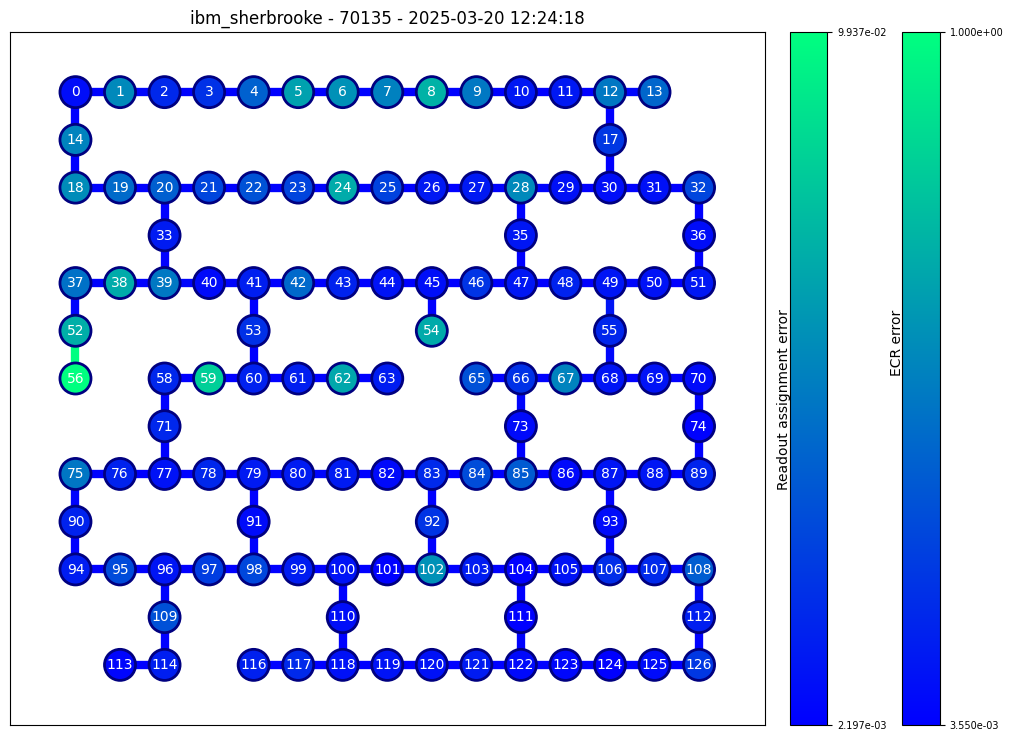

In [30]:
G, pos = create_full_graph(cm_sorted, coords, edge_weights)

# Remove Nodes
for n in nodes_list_readout:
    G.remove_node(n)

cal_id = last_cal_id
node_errors = generate_node_errors(G, conn, cal_id)
edge_errors = generate_edge_errors(G, conn, cal_id)

plt = generate_figures(G, pos, node_errors, edge_errors, show_bar = True, title=f"{hw_name} - {cal_id} - {cal_datetime}")
plt.show()

In [31]:
idx = 0
flag_success = False

while not flag_success:

    try:
        # circ = polar_circuits_x_meas_data[3]
        # reps = 8
        compiled_circuits = multiprogram_compilation_qiskit([circ]*reps,backend, exclude_qubits = nodes_list_readout)
        
        num_clbits = circ.num_clbits
        total_num_clbits = circ.num_clbits * reps
        total_num_clbits

        flag_success = True
    
    except:
        idx = idx + 1
        print(f"retry-{idx}")
        if idx > 50:
            flag_success = True

final_circuit_qc_ro = merge_circuits(compiled_circuits, backend, num_cbits=total_num_clbits)
print(used_qubits(final_circuit_qc_ro))

[0, 1, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 52, 53, 58, 59, 60, 69, 70, 71, 73, 74, 76, 77, 82, 83, 84, 85, 86, 87, 88, 89, 99, 100, 101, 102, 103, 104, 110, 111, 118, 119, 120, 121, 122]


## CX + Readout

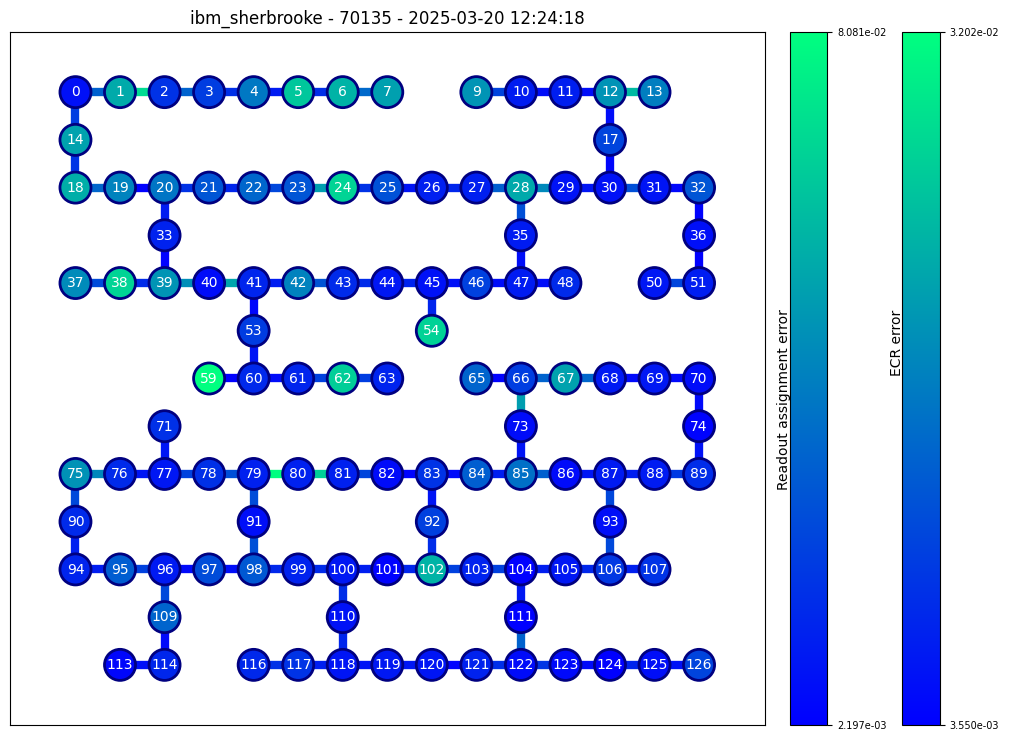

In [32]:
G, pos = create_full_graph(cm_sorted, coords, edge_weights)

# Remove Nodes
for n in nodes_list:
    G.remove_node(n)

cal_id = last_cal_id
node_errors = generate_node_errors(G, conn, cal_id)
edge_errors = generate_edge_errors(G, conn, cal_id)

plt = generate_figures(G, pos, node_errors, edge_errors, show_bar = True, title=f"{hw_name} - {cal_id} - {cal_datetime}")
plt.show()

In [33]:
idx = 0
flag_success = False

while not flag_success:

    try:
        # circ = polar_circuits_x_meas_data[3]
        # reps = 8
        compiled_circuits = multiprogram_compilation_qiskit([circ]*reps,backend, exclude_qubits = nodes_list)
        
        num_clbits = circ.num_clbits
        total_num_clbits = circ.num_clbits * reps
        total_num_clbits

        flag_success = True
    
    except:
        idx = idx + 1
        print(f"retry-{idx}")
        if idx > 50:
            flag_success = True

final_circuit_qc_cxro = merge_circuits(compiled_circuits, backend, num_cbits=total_num_clbits)
used_qbs = used_qubits(final_circuit_qc_cxro)

retry-1


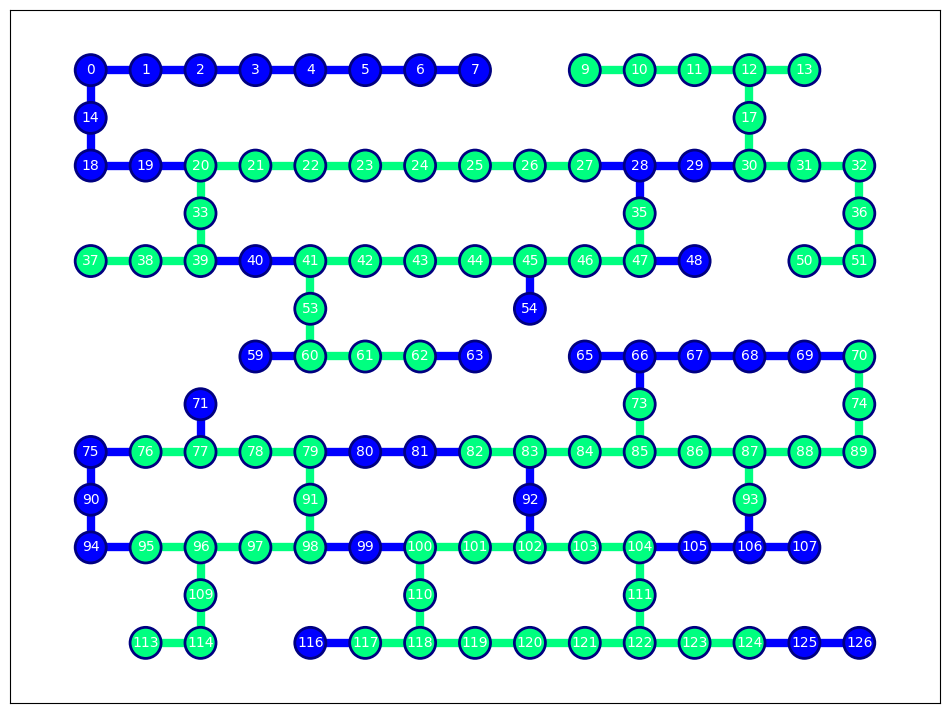

In [34]:
G, pos = create_full_graph(cm_sorted, coords, edge_weights)

edge_colors = ["navy"]*qubits_no

# Remove Nodes
for n in nodes_list:
    G.remove_node(n)

node_errors = []
edge_errors = []

for idx, j in enumerate(G.nodes()):
    if j in used_qbs :
        node_errors.append(1)
    else:
        node_errors.append(0)

for i in G.edges():
    # edge_errors.append(G.get_edge_data(i[0],i[1])["weight"])

    if i[0] in used_qbs and i[1] in used_qbs:
        edge_errors.append(1)
    else:
        edge_errors.append(0)
    
    #print(G.get_edge_data(i[0],i[1])["weight"])

plt = generate_figures(G,pos, node_errors, edge_errors, title="", edge_colors=edge_colors)
# plt.show()
# plt.tight_layout()
plt.savefig(f"mp_{hw_name}_q-3-cxro_polar_{circ_name}_{reps}.png", dpi=500)
# plt.savefig("kyiv_+_11_70k_hotmap.png", dpi=500)

## LF Layout

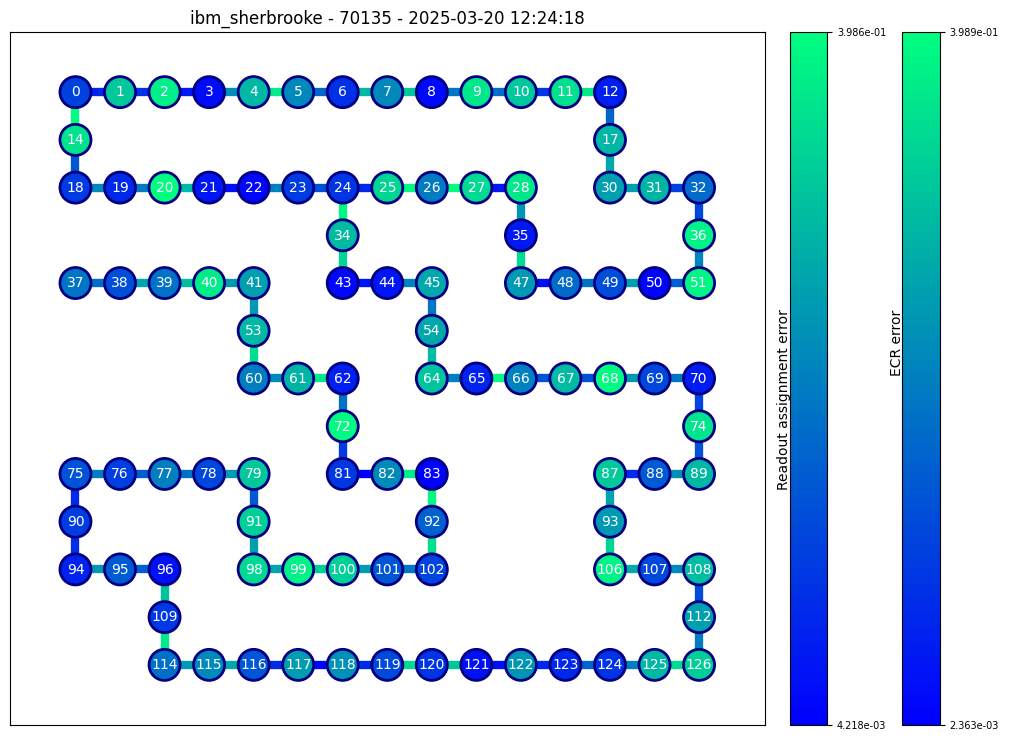

In [35]:
LF_100 = get_LF_qubits(hw_name, 100, conn)
G, pos = create_full_graph(cm_sorted, coords, edge_weights)
rem_qubits_LF_100 = []

total_rem = 0

# Remove Nodes
for i in range(backend.num_qubits):
    # if i not in LF_100 and i in nodes_list:
    if i not in LF_100:
        G.remove_node(i)
        rem_qubits_LF_100.append(i)
        
        total_rem = total_rem + 1

    # if total_rem > 23:
    #     break


cal_id = last_cal_id
node_errors = generate_node_errors(G, cal_id)
edge_errors = generate_edge_errors(G, cal_id)


plt = generate_figures(G, pos, node_errors, edge_errors, show_bar = True, title=f"{hw_name} - {cal_id} - {cal_datetime}")
plt.show()

In [36]:
print(total_rem, len(G.nodes()))

27 100


In [37]:
presets_cm = get_LF_presets_cm(backend, LF_100, circ.num_qubits)

In [38]:
idx = 0
flag_success = False

while not flag_success:

    try:
        # circ = polar_circuits_x_meas_data[3]
        # reps = 1
        compiled_circuits = multiprogram_compilation_qiskit([circ]*reps,backend, exclude_qubits = rem_qubits_LF_100)
        # compiled_circuits = multiprogram_compilation_qiskit([circ]*reps,backend, presets_cm=presets_cm)
        
        
        num_clbits = circ.num_clbits
        total_num_clbits = circ.num_clbits * reps
        total_num_clbits

        flag_success = True
    
    except:
        idx = idx + 1
        # print(f"retry-{idx}")

        if idx > 50:
            flag_success = True

print(idx)
        

final_circuit_qc_lf = merge_circuits(compiled_circuits, backend, num_cbits=total_num_clbits)

used_qbs = used_qubits(final_circuit_qc_lf)
print(used_qbs, len(used_qbs))

0
[7, 8, 9, 10, 11, 12, 17, 23, 24, 25, 26, 30, 31, 32, 34, 36, 43, 44, 45, 51, 53, 54, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 72, 74, 75, 76, 77, 78, 79, 81, 82, 83, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 100, 101, 102, 106, 107, 108, 109, 112, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126] 72


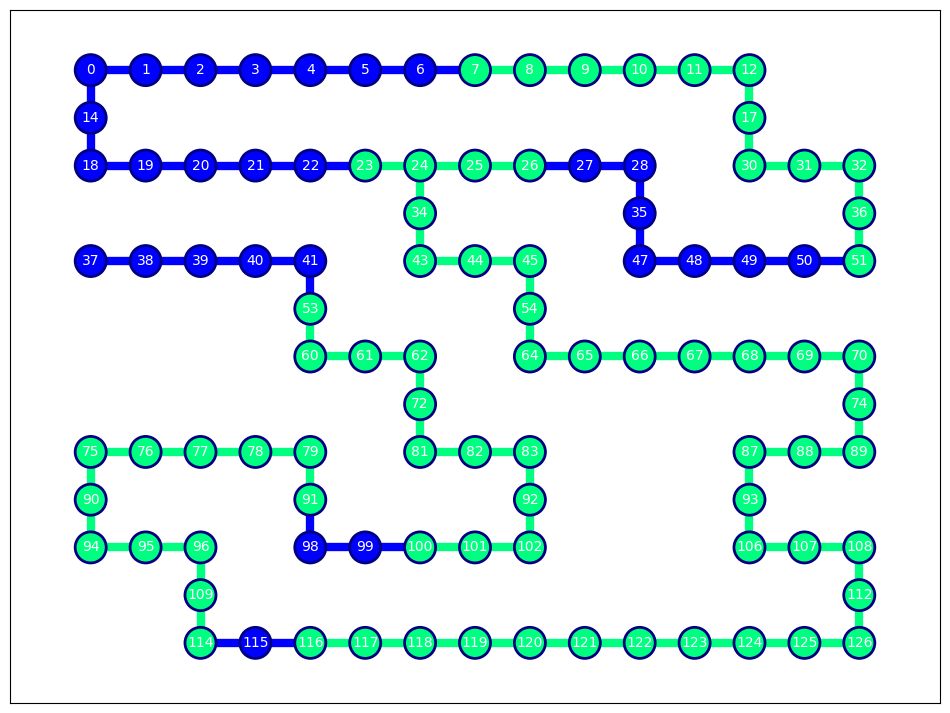

In [39]:
G, pos = create_full_graph(cm_sorted, coords, edge_weights)

edge_colors = ["navy"]*qubits_no

# Remove Nodes
for n in rem_qubits_LF_100:
    G.remove_node(n)

node_errors = []
edge_errors = []

for idx, j in enumerate(G.nodes()):
    if j in used_qbs :
        node_errors.append(1)
    else:
        node_errors.append(0)

for i in G.edges():
    # edge_errors.append(G.get_edge_data(i[0],i[1])["weight"])

    if i[0] in used_qbs and i[1] in used_qbs:
        edge_errors.append(1)
    else:
        edge_errors.append(0)
    
    #print(G.get_edge_data(i[0],i[1])["weight"])

plt = generate_figures(G,pos, node_errors, edge_errors, title="", edge_colors=edge_colors)
# plt.show()
# plt.tight_layout()
plt.savefig(f"mp_{hw_name}_q-3-lf-cxro_polar_{circ_name}_{reps}.png", dpi=500)
# plt.savefig("kyiv_+_11_70k_hotmap.png", dpi=500)

# Combining Everything

## Send one circuit

In [3]:
from qEmQUIP import QEM, conf
import mysql.connector

mysql_config = {
    'user': 'handy',
    'password': 'handy',
    'host': 'localhost',
    'database': 'framework'
}

token = "9e068d694502429634a4706a9f08781beac043c44af9642dfe89757093b049ba266b0ce9f488d4220d386114b5f785a518827881e0645b530203026ad7ab9d7e"
q = QEM(runs=conf.runs, user_id=conf.user_id, token=token, skip_db=True)


Connecting to quantum service...
Saving IBM Account...
Retrieving the real backend information of ibm_sherbrooke...


In [6]:
# prepare the circuit
qasm_files = q.get_qasm_files_from_path("./circuits/polar_sim/n3/x")
print(qasm_files)

# select compilation techniques
compilations = ["qiskit_3"]

./circuits/polar_sim/n3/x
['./circuits/polar_sim/n3/x/polar_all_meas_n3_x.qasm']


In [5]:
q = QEM(runs=conf.runs, user_id=conf.user_id, token=token)
q.send_to_real_backend("sampler", qasm_files, compilations)

Connecting to quantum service...
Saving IBM Account...
Retrieving the real backend information of ibm_sherbrooke...
Compiling circuit: polar_all_meas_n3_x for compilation: qiskit_3
Total send to real backend : 1
Total no of circuits : 1
Sending to ibm_sherbrooke with batch id: 512 ... 
Sent!


In [42]:
q.get_qiskit_result()

Pending jobs:  1
Checking results for:  cze23keqadq0008cwra0 with header id : 511 9e068d694502429634a4706a9f08781beac043c44af9642dfe89757093b049ba266b0ce9f488d4220d386114b5f785a518827881e0645b530203026ad7ab9d7e
Job status : DONE
Executed jobs : 1
Getting qasm for : 511 cze23keqadq0008cwra0
get metrics: n = 3 , lstate = X
number of discarded states (invalid measurement results) =  0
 number of accepted states   (valid measurement results) =  0
        number of logical errors on the accepted states  =  0
polar_all_meas_n3_x None qiskit_3 0 0 0 0
get metrics: n = 3 , lstate = X
number of discarded states (invalid measurement results) =  0
 number of accepted states   (valid measurement results) =  0
        number of logical errors on the accepted states  =  0
polar_all_meas_n3_x None qiskit_3 0 0 0 0
get metrics: n = 3 , lstate = X
number of discarded states (invalid measurement results) =  0
 number of accepted states   (valid measurement results) =  0
        number of logical errors 

In [56]:
#aaa = QuantumCircuit.from_qasm_str(updated_qasm)
#circuit_dd = q.apply_dd(aaa, q.real_backend, sequence_type="XX", scheduling_method="asap")
#circuit_dd.count_ops()

OrderedDict([('delay', 262),
             ('rz', 252),
             ('sx', 143),
             ('x', 96),
             ('ecr', 60),
             ('measure', 20),
             ('reset', 12)])

## Compile multiprogramming

In [6]:
token = "9e068d694502429634a4706a9f08781beac043c44af9642dfe89757093b049ba266b0ce9f488d4220d386114b5f785a518827881e0645b530203026ad7ab9d7e"
q = QEM(runs=conf.runs, user_id=conf.user_id, token=token, skip_db=False)

# prepare the circuit
qasm_files = q.get_qasm_files_from_path("./circuits/polar_sim/n3/x")
print(qasm_files)

# select compilation techniques
compilations = ["qiskit_3"]

q.set_backend(program_type="sampler")

Connecting to quantum service...
Saving IBM Account...
Retrieving the real backend information of ibm_sherbrooke...
./circuits/polar_sim/n3/x
['./circuits/polar_sim/n3/x/polar_all_meas_n3_x.qasm']


In [7]:
#q.compile_multiprogramming(qasm_files*3, compilations)
q.send_to_real_backend("sampler", qasm_files*2, compilations, enable_mp=True, mp_execution_type="all")

Total send to real backend : 1
Total no of circuits : 3
Sending to ibm_sherbrooke with batch id: 515 ... 
Sent!


## Send to backend

In [60]:

print(used_qubits(final_circuit_q3_normal))
# print(used_qubits(final_circuit_qc_cxro))
# print(used_qubits(final_circuit_qc_lf))


[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 53, 54, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 74, 75, 76, 77, 78, 79, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 110, 111, 118, 119, 120, 121, 122]


In [43]:
lstate = "X"
n = 3

job  = service.job("cze23keqadq0008cwra0") 


In [44]:
hardware_counts = []

from qiskit.providers.jobstatus import JobStatus
fidelities = []

if job.status() == JobStatus.ERROR:
    logger.error("job error")
    exit(1)

inputs_pubs = job.inputs["pubs"]

job_pubs = []
for c in inputs_pubs:
    job_pubs.append(c[0])
    # print(used_qubits(c[0]), len(used_qubits(c[0])))

qc = job_pubs[-1]
used_qbs = used_qubits(qc)
# print(used_qubits(qc), len(used_qubits(qc)))

result = job.result()

for h in result:
    hardware_counts.append(h.data.c.get_counts())

print("Total circuits:", len(hardware_counts))

pubs_zz = []
pubs_clean = []
pubs_clean_zz = []

for qc in job_pubs:
    pubs_zz.append(add_zz_on_simultaneous_cnot(qc, backend))

    tmp = avoid_simultaneous_cnot(qc, backend)
    tmp = avoid_simultaneous_cnot(tmp, backend)
    tmp = avoid_simultaneous_cnot(tmp, backend)
    pubs_clean.append(tmp)
    pubs_clean_zz.append(add_zz_on_simultaneous_cnot(tmp, backend))

pubs_zz_ops = []
pubs_clean_zz_ops = []

for idx, i in enumerate(job_pubs):
    pubs_zz_ops.append(pubs_zz[idx].count_ops())
    pubs_clean_zz_ops.append(pubs_clean_zz[idx].count_ops())

Total circuits: 1


In [49]:
result

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4000, num_bits=20>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-03-20 19:10:03', stop='2025-03-20 19:10:09', size=4000>)])}, 'version': 2})

In [45]:
pubs_zz_ops[-1]

OrderedDict([('rz', 234),
             ('sx', 132),
             ('ecr', 58),
             ('measure', 20),
             ('x', 12),
             ('reset', 8),
             ('rzz', 4)])

In [46]:
pubs_clean_zz_ops[-1]

OrderedDict([('rz', 234),
             ('sx', 132),
             ('ecr', 58),
             ('measure', 20),
             ('x', 12),
             ('reset', 8),
             ('id', 7)])

In [48]:
end_index = None
start_index = None

res = sum_middle_digits_dict(hardware_counts[0], end_index, start_index)
print(get_logical_error_on_accepted_states(n, lstate, res))

start_index = end_index

number of discarded states (invalid measurement results) =  3477
 number of accepted states   (valid measurement results) =  523
        number of logical errors on the accepted states  =  262
(523, 262, 343, 0.49904397705544934, 0.1375293529999908, -0.0077913100003570435)


In [ ]:
lstate = "X"
n = 3

for idx in range(1,len(hardware_counts)):
    h_res = hardware_counts[idx]

    total_accepted = 0
    
    for key, value in h_res.items():
        end_index = 0
        start_index = None
        
        total_partition = int(len(key) / num_clbits)
        # total_partition = 6

        # print(len(key), total_partition, value)
    
        total_count_accept = 0
        for i in range(total_partition):
            end_index = end_index - num_clbits
    
            tmp_dict = {key[end_index : start_index]:1}
            # res = sum_middle_digits_dict(hardware_counts[-1], end_index, start_index)
            # print(f"Reps-{i}")
            count_accept, _, _, _, _, _ =   get_logical_error_on_accepted_states(n, lstate, tmp_dict)
            total_count_accept = total_count_accept + count_accept
            
            start_index = end_index
    
        if total_count_accept > 0:
            total_accepted = total_accepted + 1
        

    print(idx, total_partition, total_accepted)